In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import scqubits as scq
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep

import numpy as np

np.set_printoptions(threshold=10, edgeitems=2)

## Parameter sweeps in composite Hilbert spaces
Composite Hilbert spaces, as defined by `HilbertSpace` objects, are more complicated than individual qubits. A variety of parameter sweeps can be considered, including multi-dimensional sweeps over a collection of parameters. A parameter to be varied does not need to be one of the initialization parameters. Instead it could be a coupling strength or some other derived quantity. 

.. note::
    The `ParameterSweep` class has undergone significant changes in v1.4 and now supports multi-parameter scans.
    The old interface is still intact, but will be phased out with future releases.

For flexible parameter scans, scqubits provides the `ParameterSweep` class. To illustrate its usage, we first define a composite Hilbert space - using the example of two tunable transmon qubits coupled to an oscillator. (See the `HilbertSpace` section in the user guide for details on this topic.) 

In [2]:
tmon1 = scq.TunableTransmon(
    EJmax=40.0,
    EC=0.2,
    d=0.1,
    flux=0.0,
    ng=0.3,
    ncut=40,
    truncated_dim=3     # after diagonalization, we will keep 3 levels
)

tmon2 = scq.TunableTransmon(
    EJmax=15.0,
    EC=0.15,
    d=0.2,
    flux=0.0,
    ng=0.0,
    ncut=30,
    truncated_dim=3
)

resonator = scq.Oscillator(
    E_osc=4.5,
    truncated_dim=4    # up to 3 photons (0,1,2,3)
)

hilbertspace = scq.HilbertSpace([tmon1, tmon2, resonator])


g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

hilbertspace.add_interaction(
    g_strength = g1,
    op1 = tmon1.n_operator,
    op2 = resonator.creation_operator,
    add_hc = True
)

hilbertspace.add_interaction(
    g_strength = g2,
    op1 = tmon2.n_operator,
    op2 = resonator.creation_operator,
    add_hc = True
)

### Creating a ParameterSweep object

The `ParameterSweep` class facilitates computation of spectra as function of one or multiple external parameter(s). For efficiency in computing a variety of derived quantities and creating plots, the computed bare and dressed spectral data are stored internally. 

A `ParameterSweep` object is initialized by providing the following parameters:

1. `hilbertspace`: a `HilbertSpace` object that describes the quantum system of interest
2. `paramvals_by_name`: a dictionary that maps each parameter name (string) to an array of parameter values 
3. `update_hilbertspace`: a function that defines how parameters changes affect the system
4. `subsys_update_info`: (optional) for potential speed-up, specify which subsystems undergo changes as each of the parameters is varied
5. `num_cpus`: (optional) number of CPU cores requested for the sweep evaluation

(See the API documentation for additional options.)

These ingredients all enter as initialization arguments of the `ParameterSweep` object. Once initialized, spectral data is generated and stored.

In our example, we consider the strength of a global magnetic field as the parameter to be changed. This field determines the magnetic fluxes for both qubits, in proportions according to their SQUID loop areas. We will reference the flux for transmon 1, and express the flux for transmon 2 in terms of it via an area ratio. In addition, we will vary the offset charge of transmon 2.

In [4]:
pname1 = 'flux'  # name of varying external parameter
flux_vals = np.linspace(0.0, 2.0, 151)  # parameter values
pname2 = 'ng'
ng_vals = np.linspace(-0.5, 0.5, 51)

paramvals_by_name = {pname1: flux_vals, pname2: ng_vals}


area_ratio = 1.2

def update_hilbertspace(flux, ng):          # function that defines how Hilbert space components are updated
    tmon1.flux = flux
    tmon2.flux = area_ratio * flux
    tmon2.ng = ng

subsys_update_info = {pname1: [tmon1, tmon2],
                      pname2: [tmon2]}

    
    
sweep = ParameterSweep(
    hilbertspace=hilbertspace,
    paramvals_by_name=paramvals_by_name,
    update_hilbertspace=update_hilbertspace,
    evals_count=20,
    subsys_update_info=subsys_update_info,
    num_cpus=4
)

### ParameterSweep data: using NamedSlotsNdarray

Much of the computed data that is stored and immediately retrievable after this sweep by accessing the `ParameterSweep` object like a dictionary with the following string keys:


+-------------------------------+------------------------------------------------------------------------+
| string keyword                |    data                                                                |
+===============================+========================================================================+
| `"evals"`, `"evecs"`          | dressed eigenenergies and eigenstates as `NamedSlotsNdarray`           |
|                               | eigenstates are decomposed in the bare product-state basis of the      |
|                               | non-interacting subsystems' eigenbases                                 |
+-------------------------------+------------------------------------------------------------------------+
| `"bare_evals"`, `"bare_evecs"`| eigenenergies and eigenstates for each subsystem as `NamedSlotsNdarray`|         
|                               | The arrays first axis (name: `"subsys"` enumerates the subsystems      |
+-------------------------------+------------------------------------------------------------------------+
| `"lamb"`, `"chi"`, `"kerr"`   | dispersive energy coefficients as `NamedSlotsNdarray`                  |
|                               | (see description below)                                                |
+-------------------------------+------------------------------------------------------------------------+


Data are returned as a `NamedSlotsNdarray` which behaves like a regular numpy array:

In [5]:
sweep["evals"]

NamedSlotsNdarray([[[-48.9786042 , -45.0278778 , ..., -29.62856751,
                     -29.01322673],
                    [-48.97848114, -45.02775481, ..., -29.62844554,
                     -29.0131401 ],
                    ...,
                    [-48.98108696, -45.03035937, ..., -29.63102837,
                     -29.01497731],
                    [-48.98131859, -45.03059088, ..., -29.63125795,
                     -29.01514089]],

                   [[-48.92870243, -44.97998573, ..., -29.58765866,
                     -28.97077435],
                    [-48.92857938, -44.97986273, ..., -29.5875367 ,
                     -28.97068746],
                    ...,
                    [-48.9311852 , -44.98246729, ..., -29.59011952,
                     -28.97253023],
                    [-48.93141683, -44.9826988 , ..., -29.5903491 ,
                     -28.9726943 ]],

                   ...,

                   [[-40.75613593, -38.25143315, ..., -23.63704242,
                     

#### Parameter information
For convenience, `NamedSlotsNdarray` stores information about the parameters along with the array. Our array has the shape

In [6]:
sweep["evals"].shape

(151, 51, 20)

The associated parameters are obtained through the `NamedSlotsNdarray` attribute `param_info`:

In [7]:
sweep["evals"].param_info

OrderedDict([('flux',
              array([0.        , 0.01333333, ..., 1.98666667, 2.        ])),
             ('ng', array([-0.5 , -0.48, ...,  0.48,  0.5 ]))])

There are two names axes, one for the flux parameter, one for the offset charge parameter. The last (unnamed) axis is for the number of eigenvalues at each point (the default is 20).

The `param_info` entries are kept up-to-date upon slicing an `NamedSlotsNdarray`:

In [8]:
sliced_data = sweep["evals"][0, :]   # fix flux to the first parameter value and keep all ng values
print(sliced_data.shape)
print(sliced_data.param_info)

(51, 20)
OrderedDict([('ng', array([-0.5 , -0.48, ...,  0.48,  0.5 ]))])


Once all named axes have been collapsed, we return to an ordinary numpy array:

In [9]:
sweep["evals"][3, 5]

array([-48.52964551, -44.59713777, ..., -29.26070653, -28.63168738])

#### Generalized slicing with NamedSlotsNdarray

**Name-based slicing**.
While the order of axes in a `NamedSlotsNdarray` is maintained consistently, referring to an axis by its name can be convenient. In this name-based slicing, order of index entries does not matter:

In [10]:
(sweep["evals"]["flux":5, "ng":7], 
 sweep["evals"]["ng":7, "flux":5])

(array([-47.7361842 , -43.83676192, ..., -28.61225398, -27.9590524 ]),
 array([-47.7361842 , -43.83676192, ..., -28.61225398, -27.9590524 ]))

Name-based slicing allows for `start` and `stop`. For example, `["flux":3:-2]` chooses the flux parameter values from element 4 to the second-but-last element. (A `step` entry is not supported for name-based slicing.)

.. note::
    Name-based slicing and ordinary slicing by axes position cannot be mixed. If a multi-index contains a 
    name-based entry, then all entries must be name-based.  

**Value-based slicing**.
Generalized slicing includes the possibility to refer to an array axis by a parameter value rather than through its index. One downside of this: the parameter value needs to be entered in full with all relevant decimals. This option therefore makes most sense when parameter value arrays are built commensurate with simple decimals.

Example: the ng value 0.0 is one value in the ng parameter array. We can access it via

In [11]:
sweep["evals"][:, 0.0]

NamedSlotsNdarray([[-48.9776994 , -45.02697343, ..., -29.62767069,
                    -29.01259019],
                   [-48.92779763, -44.97908136, ..., -29.58676184,
                    -28.97013586],
                   ...,
                   [-40.75523166, -38.25049728, ..., -23.63707651,
                    -22.86321975],
                   [-40.26251587, -37.8914427 , ..., -23.40840165,
                    -22.49727021]])

Value-based and string-based slicing can be combined. The following thus produces the same result:

In [12]:
sweep["evals"]["ng":0.0]

NamedSlotsNdarray([[-48.9786042 , -45.0278778 , ..., -29.62856751,
                    -29.01322673],
                   [-48.92870243, -44.97998573, ..., -29.58765866,
                    -28.97077435],
                   ...,
                   [-40.75613593, -38.25143315, ..., -23.63704242,
                    -22.86414811],
                   [-40.26341946, -37.89241505, ..., -23.40746803,
                    -22.49823508]])

#### Quick plotting of sweep data
Once a `NamedSlotsNdarray` is reduced to a single parameter axis, data can readily be plotted using the `plot()` method:

(<Figure size 900x600 with 1 Axes>, <AxesSubplot:xlabel='flux'>)

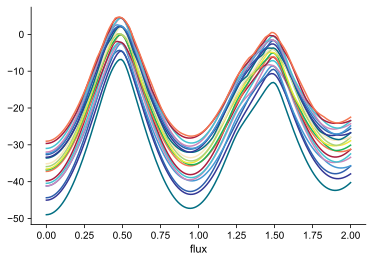

In [13]:
sweep["evals"][:,0].plot()

This result looks odd at first glance: where, for instance, is the flux-independent resonator line? The reason for the unfamiliar appearance is that we are plotting eigenvalues without subtracting the ground state energy. For that, see the `.transitions()` and `.plot_transitions()` methods below.

### Transition plots
Energy spectra obtained in single-tone or two-tone spectroscopy always represent transitions energies, rather than absolute energies of individual eigenstates. To generate data mimicking this, appropriate differences between eigenenergies must be taken.

The methods for generating transition energy data and plotting them are `<ParameterSweep>.transitions(...)` and `<ParameterSweep>.plot_transitions(...)`. To create a plot, we  use **"pre-slicing"** of the `ParameterSweep` instance to specify a sweep along a single axis, and then call `.plot_transitions()`.

.. note::
    **Pre-slicing** applies to `ParameterSweep` objects. It uses numpy or generalized slicing notation to 
    specify a subset of the sweep. For plotting, the resulting subset should be a one-dimensional sweep. Note that 
    pre-slicing does not actually discard any data. Rather, it internally marks the selected sub-sweep which is 
    then looked up when applying `.transitions()` or `plot_transitions()`.

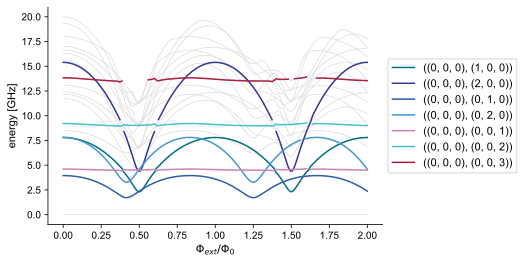

In [14]:
sweep["ng":0.0].plot_transitions();

  The generated transition plot is based on default choices:

* The origin of each transition is the system's ground state.
* Only single-photon transitions are included.
* Transitions are generally plotted in light grey. 
* By default, transitions among states of individual subsystems are marked separately and accompanied by a legend. This is possible in regions where the dispersive approximation holds, i.e., hybridization between subsystems remains weak.
* Labels in the legend us excitation levels of individual systems: ((0,0,0), (1,0,0)) denotes a transition from the ground state to the state with subsystem 1 (here: `tmon1`) in the first excited state, and subsystems 2 and 3 in their respective ground states.

One peculiarity is nearly unavoidable when coloring transitions according to the dispersive-limit state labeling: whenever states undergo avoided crossings and the dispersive limit breaks down, coloring must discontinuously switch from one branch to another. scqubits attempts to interrupt coloring in such regions. However, if the avoided crossing is so narrow that it occurs between two adjacent parameter values, then discontinuities from connecting separate branches will remain visible.

### Transition plot options
Multiple aspects of transition energy plots can be changed. The following gives a quick overview; see the API documentatation for a comprehensive discussion of options.

#### `coloring`
If ordinary coloring is preferred, this can be obtained by choosing `"plain"` coloring:

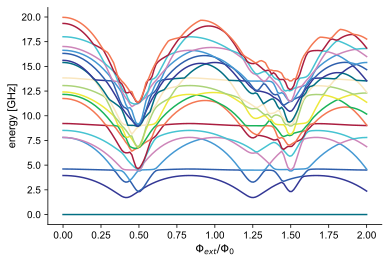

In [15]:
sweep["ng":0.0].plot_transitions(coloring="plain");

#### `subsystems`
When coloring transitions according to nature of the transition, all subsystems are included by default. If transitions for a single or smaller set of subsystem(s) should be highlighted, then these are specified in list form:

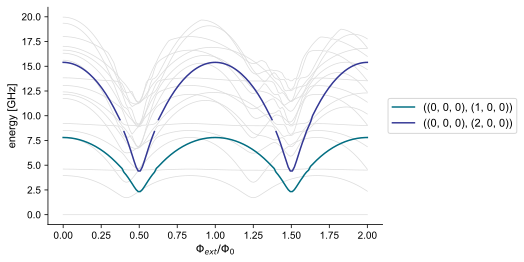

In [16]:
sweep["ng":0.0].plot_transitions(subsystems=[tmon1]);

#### `initial` and `final`
By default, the ground state is taken as origin for all transitions. In case of thermal excitations, other states can be of interest as initial states. Specification of an alternative initial state uses dispersive labeling of states:

e.g., (1,0,0) uses the 1st excited `tmon1` state as the initial state:

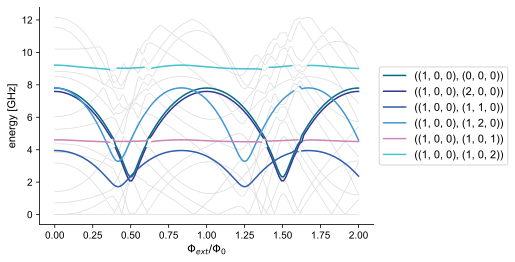

In [17]:
sweep["ng":0.0].plot_transitions(initial=(1,0,0));

Similarly `final` option may be used if only the transitions to a specific state should be highlighted:

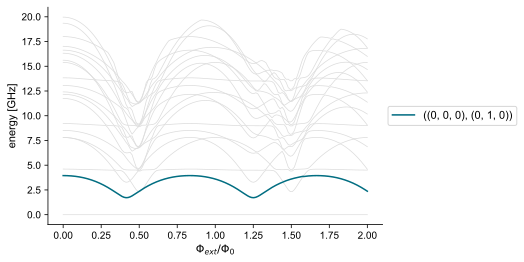

In [19]:
sweep["ng":0.0].plot_transitions(final=(0,1,0));

#### `make_positive`
When considering excited as in the previous example, some of the transition energies will naturally be negative. Experimentally, these transitions are driven at the absolute frequency. By default, absolute values of transition energies are displayed. This can be disabled by setting `make_positive=False`.


#### `sidebands`
By default, sideband transitions are not highlighted. If set to true, sideband transitions with multiple subsystems changing excitation levels are included as well:

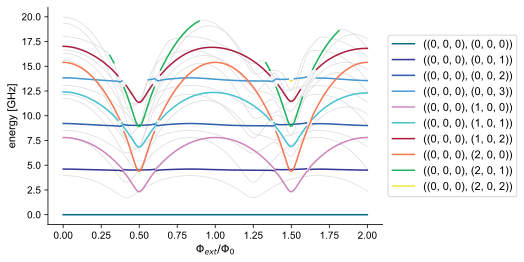

In [20]:
sweep["ng":0.0].plot_transitions(subsystems=[tmon1, resonator], sidebands=True);

### Custom sweeps
`ParameterSweep` generates data commonly needed in a multi-component quantum system. Other quantities of interest can be generated by defining a custom sweep function generating the data and calling `<ParameterSweep>.add_sweep(...)`.

To do so, define a function of the following form:

``def custom_func(paramsweep, paramindex_tuple, paramvals_tuple, **kwargs):
    ...
    return data``
    
As a toy example, here is a function that returns the 01 charge matrix element for `tmon2` at each parameter point:

In [38]:
def tmon2_n01(paramsweep, paramindex_tuple, paramvals_tuple, **kwargs):
    # We could recalculate matrix elements from scratch, but it is advantageous to use the bare spectral 
    # data we have already calculated.
    bare_evecs = sweep["bare_evecs"]["subsys":1][paramindex_tuple]
    n_matrix_elements = tmon2.matrixelement_table(
        operator="n_operator",
        evecs=bare_evecs,
        evals_count=tmon2.truncated_dim,
    )
    return np.abs(n_matrix_elements[0,1])

The `add_sweep` method takes the callable function one argument, and the name under which the scan should be stored as the second argument:

In [39]:
sweep[:].add_sweep(tmon2_n01, "n01")

Pre-slicing is required; here the sweep is to extend over all parameter sets associated with sweep. The resulting data is accessible by dict-like access, and yields a `NamedSlotsNdarray`:

In [40]:
sweep["n01"]

NamedSlotsNdarray([[1.30478755, 1.30478755, ..., 1.30478755, 1.30478755],
                   [1.30437594, 1.30437594, ..., 1.30437594, 1.30437594],
                   ...,
                   [1.02671184, 1.02671183, ..., 1.02671183, 1.02671184],
                   [0.99863368, 0.99863367, ..., 0.99863367, 0.99863368]])

We can easily take a slice for fixed flux and plot the result:

(<Figure size 900x600 with 1 Axes>, <AxesSubplot:xlabel='ng'>)

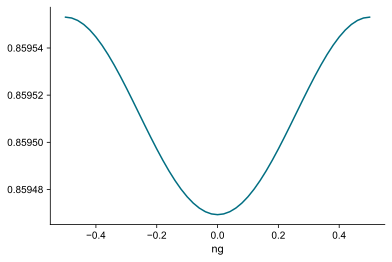

In [45]:
sweep["n01"]["flux":30].plot()